In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import pandas as pd


In [33]:
#lading the mnist dataset
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_digits = np.concatenate([x_train], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_digits=mnist_digits.reshape(60000,28,28,1)

4423680/4422102 [==============================] - 0s 0us/step


In [34]:
mnist_digits=(mnist_digits-0.5)/0.5

In [35]:
mnist_digits.min()

-1.0

In [36]:
def plot_generated_images(epoch, generator, examples=10, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(0,1,(examples, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28,1)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.title(str(epoch))
        plt.imshow(generated_images[i,:,:,0], interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [37]:
#generator


input2=layers.Input(shape=(100))
#input2=e1

d1=layers.Dense(7*7*128,name='generator_starts')(input2)
d1=layers.LeakyReLU(alpha=0.2)(d1)
d1=layers.Reshape((7,7,128))(d1)


c6=layers.Conv2DTranspose(64,(4,4),padding='same',strides=2)(d1)
c6=layers.LeakyReLU(alpha=0.2)(c6)

c7=layers.Conv2DTranspose(32,(4,4),padding='same',strides=2)(c6)
c7=layers.LeakyReLU(alpha=0.2)(c7)

c8=layers.Conv2DTranspose(1,(4,4),padding='same')(c7)
c8=tf.keras.activations.tanh(c8)
#change to sigmoid and experiment

de1=c8


gen=keras.Model(input2,c8,name='generator')

gen.summary()

gen.compile(optimizer= tf.keras.optimizers.Adam(lr=0.0002,beta_1=0.5), loss = 'binary_crossentropy')

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator_starts (Dense)     (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        131136    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        32

In [38]:
#discriminator

input1=layers.Input(shape=(28,28,1))
c1=layers.Conv2D(32,(4,4),padding='same')(input1)
c1=layers.LeakyReLU(alpha=0.2)(c1)
c1=layers.Dropout(0.2)(c1)

c2=layers.Conv2D(64,(4,4),padding='same',strides=2)(c1)
c2=layers.LeakyReLU(alpha=0.2)(c2)
c2=layers.Dropout(0.2)(c2)

c3=layers.Conv2D(128,(4,4),padding='same',strides=2)(c2)
c3=layers.LeakyReLU(alpha=0.2)(c3)
c3=layers.Dropout(0.2)(c3)

f=layers.Flatten()(c3)




#e1 = sampling(mean1, log_var1)


#d1 = layers.Dense(128)(f)
#d1=layers.LeakyReLU(alpha=0.2)(d1)

e1=layers.Dense(1,activation='sigmoid')(f)

dis=keras.Model(input1,e1,name='discriminator')

dis.summary()
dis.compile(optimizer= tf.keras.optimizers.Adam(lr=0.0002,beta_1=0.5), loss = 'binary_crossentropy')

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        544       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)      

In [39]:
dis.trainable=False
I1=gen.input


H1=gen(I1)
O1=dis(H1)


auto=keras.Model(I1,O1)
auto.summary()


auto.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002,beta_1=0.5), loss='binary_crossentropy')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator (Functional)       (None, 28, 28, 1)         797921    
_________________________________________________________________
discriminator (Functional)   (None, 1)                 170849    
Total params: 968,770
Trainable params: 797,921
Non-trainable params: 170,849
_________________________________________________________________


In [40]:
auto.layers[1]

In [41]:
#function to train the discriminator
def dis_train(x_train,batch_size1=32):
  #gen.trainable=False
  dis.trainable=True

  z_dim=100
  valid = np.ones((batch_size1))
  fake = np.zeros((batch_size1))

  # TRAIN ON REAL IMAGES
  idx = np.random.randint(0, x_train.shape[0], batch_size1)
  true_imgs = x_train[idx]

  #print('training the discriminator for real images')
  dis.train_on_batch(true_imgs, valid)

  # TRAIN ON GENERATED IMAGES
  noise = np.random.normal(0,1,(batch_size1,z_dim))
  #print('training the discriminator for fake images')
  gen_imgs = gen.predict(noise)
  dis.train_on_batch(gen_imgs, fake)




  



In [42]:
#function to train the the generator
def gen_train(x_train,batch_size1=32):
  #gen.trainable=True
  dis.trainable=False
  auto.layers[2].trainable=False
  z_dim=100
  valid = np.ones((batch_size1))
  noise = np.random.normal(0,1,(batch_size1,z_dim))
  #print('training the generator')
  #auto.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002,beta_1=0.5), loss='binary_crossentropy')
  auto.train_on_batch(noise, valid)



epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100

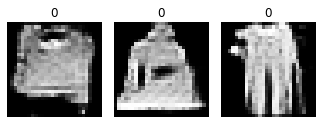

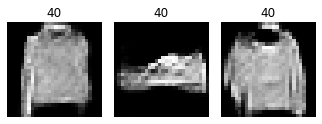

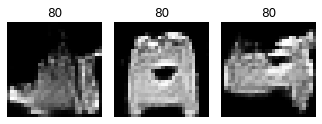

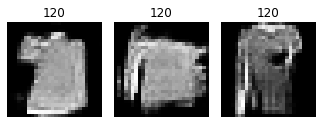

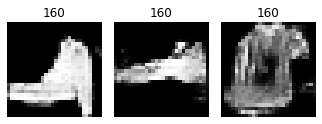

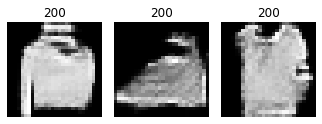

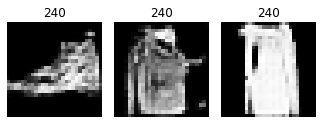

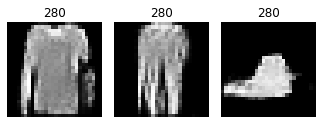

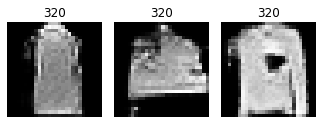

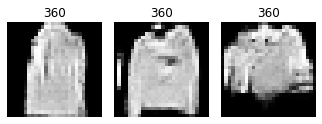

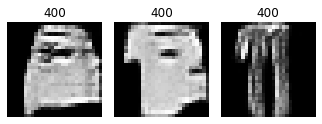

In [114]:


#training the GAN using the training functions above

epochs=400

for i in range(epochs+1):
  print("epoch:",i)
  dis_train(mnist_digits,batch_size1=64)
  gen_train(mnist_digits,batch_size1=64)
  if(i%40==0):
     plot_generated_images(i, gen, examples=3, dim=(10,10), figsize=(15,15))


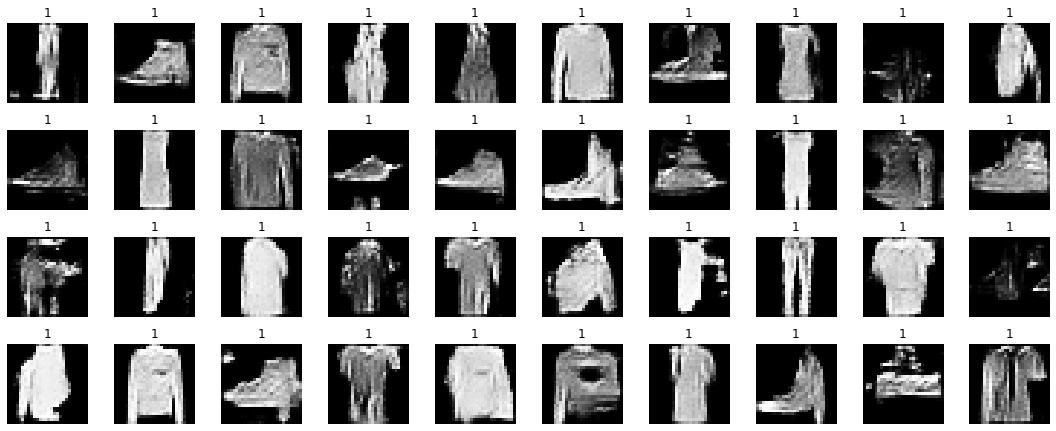

In [118]:
plot_generated_images(1, gen, examples=40, dim=(10,10), figsize=(15,15))

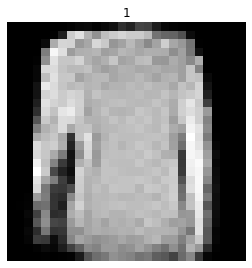

In [119]:
plot_generated_images(1, gen, examples=1, dim=(10,10), figsize=(35,35))

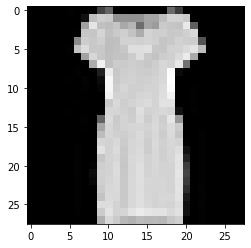

In [127]:
plt.imshow(mnist_digits[30,:,:,0],cmap='gray')

In [124]:
mnist_digits.shape

(60000, 28, 28, 1)